In [2]:
import tensorflow as tf
print(tf.__version__)

#tf.config.list_physical_devices('GPU')
#tf.test.is_gpu_available()

import os
os.environ['CUDA_VISIBLE_DEVICES']='0' 

gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)


#from tensorflow.python.client import device_lib 
#device_lib.list_local_devices()

2.4.0


In [3]:
# Importing the libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input
from tensorflow.keras.regularizers import l2

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import numpy as np

#import matplotlib.pyplot as plt
from itertools import cycle

import numpy as np

import tensorflow.keras.backend as K
K.clear_session()

In [7]:
# Generating images for the Training set
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)

# Generating images for the Test set
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

# Creating the Training set
training_set = train_datagen.flow_from_directory('./Kvasir/train', 
                                                 target_size = (224, 224),
                                                 subset='training')

# Creating the Validation set
validation_set = train_datagen.flow_from_directory('./Kvasir/train',
                                                   target_size = (224, 224),
                                                   subset='validation')

# Creating the Test set
test_set = test_datagen.flow_from_directory('./Kvasir/test',
                                             target_size = (224, 224))

Found 5920 images belonging to 8 classes.
Found 1480 images belonging to 8 classes.
Found 600 images belonging to 8 classes.


In [35]:
from collections import Counter
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
print(class_weights)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}


In [5]:
# Transfer Learning
from tensorflow.keras.models import *

pretrained_nn = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# Freeze all layers
for l in pretrained_nn.layers:
  l.trainable = False

global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()(pretrained_nn.output)
fc1 = tf.keras.layers.Dense(512, activation='relu')(global_avg_pool)
fc2 = tf.keras.layers.Dense(512, activation='relu')(fc1)
output = tf.keras.layers.Dense(8, activation='softmax')(fc2)

model = Model(pretrained_nn.input, output)

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0.001, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [38]:
# Training
from keras import callbacks
hist = model.fit(training_set,
                  steps_per_epoch = training_set.__len__(),
                  epochs = 50,
                  validation_data = validation_set,
                  validation_steps = validation_set.__len__(),
                  callbacks=[callbacks.ModelCheckpoint('cp-model.h5', save_best_only=True)])

Epoch 1/50
185/185 [==============================] - 119s 635ms/step - loss: 1.1683 - accuracy: 0.5899 - val_loss: 0.4815 - val_accuracy: 0.8074
Epoch 2/50
185/185 [==============================] - 111s 601ms/step - loss: 0.3923 - accuracy: 0.8533 - val_loss: 0.3952 - val_accuracy: 0.8473
Epoch 3/50
185/185 [==============================] - 111s 599ms/step - loss: 0.3301 - accuracy: 0.8733 - val_loss: 0.3974 - val_accuracy: 0.8405
Epoch 4/50
185/185 [==============================] - 110s 597ms/step - loss: 0.3120 - accuracy: 0.8707 - val_loss: 0.3653 - val_accuracy: 0.8459
Epoch 5/50
185/185 [==============================] - 111s 601ms/step - loss: 0.2919 - accuracy: 0.8841 - val_loss: 0.3660 - val_accuracy: 0.8412
Epoch 6/50
185/185 [==============================] - 112s 605ms/step - loss: 0.2774 - accuracy: 0.8900 - val_loss: 0.3454 - val_accuracy: 0.8601
Epoch 7/50
185/185 [==============================] - 111s 603ms/step - loss: 0.2653 - accuracy: 0.8933 - val_loss: 0.3417 -

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [8]:
model.load_weights('cp-model.h5')
score = model.evaluate(validation_set,verbose=1)

print('Valid loss:', score[0])
print('Valid acc:', score[1])

47/47 [==============================] - 28s 497ms/step - loss: 0.3033 - accuracy: 0.8732
Valid loss: 0.32599756121635437
Valid acc: 0.8608108162879944


In [10]:
preds = model.predict(test_set)

#auc = roc_auc_score(gt, preds, multi_class="ovr")
#print("auc :", auc)

# Compute ROC curve and ROC area for each class
n_classes = 8
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    y_true = np.array([j[i] for j in data_list[:]])
    y_score = preds[:, i]
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array([j for j in data_list[:]]).ravel(), preds.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

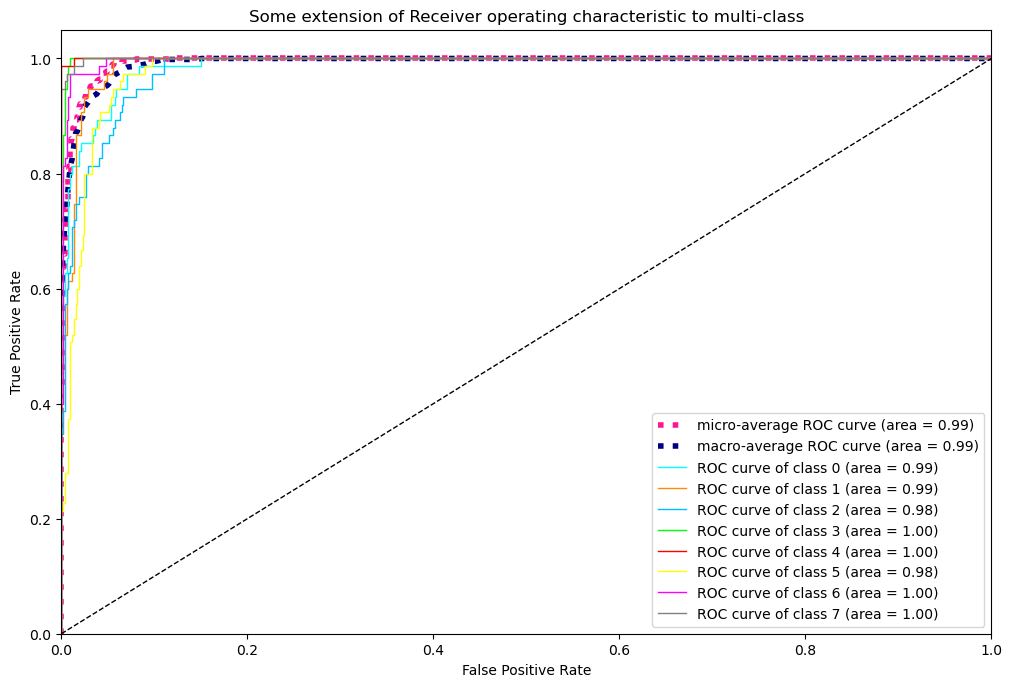

In [13]:
import matplotlib.pyplot as plt
# Plot all ROC curves
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'deepskyblue', 'lime', 'red', 'yellow', 'fuchsia', 'gray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()